In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import bp_input

In [2]:
# batch size
batch_size = 5
# input vector size
hidden_size = 300
# unroll rnn with truncated bp,
# with a fixed number of number(num_step) cells
num_steps = 53
# forget bias
forget_bias = 1.0
# keep probability
keep_prob = 0.5
# num of layers in multiple layer lstm
num_layers = 2
# num of output classes 
num_classes = 6
# max epoch
max_epoch = 30

In [3]:
(tr_d, tr_l), (te_d, te_l) = bp_input.bp_raw_data(test_size=10)

In [4]:
train_input = bp_input.BPInput(batch_size, tr_d, tr_l)

#inputs, labels = input_producer(data, label, epoch_size, batch_size, num_steps)

inputs, labels, epoch_size = train_input.inputs, train_input.targets, train_input.epoch_size
inputs = tf.unstack(inputs, num=num_steps, axis=1)

In [5]:
# inference
lstm_fw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_fw = tf.contrib.rnn.DropoutWrapper(lstm_fw, output_keep_prob=keep_prob)

multi_lstm_fw = tf.contrib.rnn.MultiRNNCell([lstm_fw] * num_layers)

initial_state_fw = multi_lstm_fw.zero_state(batch_size, tf.float32)

lstm_bw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_bw = tf.contrib.rnn.DropoutWrapper(lstm_bw, output_keep_prob=keep_prob)

multi_lstm_bw = tf.contrib.rnn.MultiRNNCell([lstm_bw] * num_layers)

initial_state_bw = multi_lstm_bw.zero_state(batch_size, tf.float32)


In [6]:
outputs, output_state_fw, output_state_bw = tf.contrib.rnn.static_bidirectional_rnn(cell_fw=multi_lstm_fw, cell_bw=multi_lstm_bw, inputs=inputs, initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw,dtype=tf.float32)

#outputs, output_state_fw, output_state_bw = tf.nn.bidirectional_dynamic_rnn(
#    cell_fw=lstm_fw, cell_bw=lstm_bw, sequence_length=[2, 3, 3,3, 5],
#    inputs=inputs, initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw,dtype=tf.float32)

#outputs

In [7]:
softmax_w = tf.get_variable("softmax_w", [2*hidden_size, num_classes], dtype=tf.float32)
softmax_b = tf.get_variable("softmax_b", [num_classes], dtype=tf.float32)

output = tf.reshape(tf.concat(outputs, 1), [-1, 2 * hidden_size])
logits = tf.matmul(output, softmax_w) + softmax_b
label_flat = tf.reshape(labels, [-1])

weights = tf.to_float(tf.clip_by_value(label_flat, clip_value_min=0, clip_value_max=2))
weights = tf.square(weights)

mask = tf.sign(weights)

loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
    logits=[logits],
    targets=[label_flat],
    weights=[mask])

cost = tf.reduce_sum(loss) / batch_size

optimizer = tf.train.GradientDescentOptimizer(0.05)
train_op = optimizer.minimize(cost)

In [8]:
prediction = tf.argmax(logits, 1) * tf.to_int64(mask)

In [9]:
def run_epoch(sess):
    sess.run(initial_state_fw)

    start_time = time.time()
    costs = 0.0
    iters = 0.0
    
    state_fw = sess.run(initial_state_fw)
    state_bw = sess.run(initial_state_bw)
    
    preds = []
    
    for step in range(epoch_size):
        feed_dict = {}
        for i, (c, h) in enumerate(initial_state_fw):
            feed_dict[c] = state_fw[i].c
            feed_dict[h] = state_fw[i].h
        for i, (c, h) in enumerate(initial_state_bw):
            feed_dict[c] = state_bw[i].c
            feed_dict[h] = state_bw[i].h
            
        c, state_fw, state_bw, _, pred = sess.run(
            [cost, output_state_fw, output_state_bw, train_op, prediction],
            feed_dict)
    
        costs += c
        iters += num_steps
    
        preds.append(pred)
    
        if step % (epoch_size // 10) == 0:
            print("%.3f perplexity: %.3f speed: %.0f wps" %
                (step * 1.0 / epoch_size, np.exp(costs / iters),
                 iters * batch_size / (time.time() - start_time)))

    return preds

In [10]:
saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=None) 
if not os.path.exists("ckpt_files"):
    os.mkdir("ckpt_files")
    
ckpt_path = "ckpt_files/model.ckpt-"

In [11]:
coord = tf.train.Coordinator()

In [13]:
ckpt_path = "ckpt_files/model.ckpt"

epoch:    0
0.000 perplexity: 1.474 speed: 91 wps
0.083 perplexity: 1.418 speed: 168 wps
0.167 perplexity: 1.373 speed: 201 wps
0.250 perplexity: 1.342 speed: 220 wps
0.333 perplexity: 1.325 speed: 232 wps
0.417 perplexity: 1.315 speed: 240 wps
0.500 perplexity: 1.312 speed: 247 wps
0.583 perplexity: 1.311 speed: 251 wps
0.667 perplexity: 1.299 speed: 255 wps
0.750 perplexity: 1.298 speed: 258 wps
0.833 perplexity: 1.291 speed: 260 wps
0.917 perplexity: 1.290 speed: 263 wps


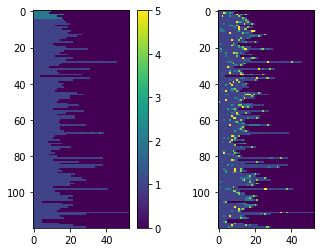

INFO:tensorflow:ckpt_files/model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
epoch:    1
0.000 perplexity: 1.264 speed: 278 wps
0.083 perplexity: 1.295 speed: 280 wps
0.167 perplexity: 1.275 speed: 246 wps
0.250 perplexity: 1.265 speed: 247 wps
0.333 perplexity: 1.265 speed: 237 wps
0.417 perplexity: 1.264 speed: 243 wps
0.500 perplexity: 1.267 speed: 248 wps
0.583 perplexity: 1.258 speed: 251 wps
0.667 perplexity: 1.251 speed: 253 wps
0.750 perplexity: 1.252 speed: 256 wps
0.833 perplexity: 1.249 speed: 258 wps
0.917 perplexity: 1.248 speed: 260 wps


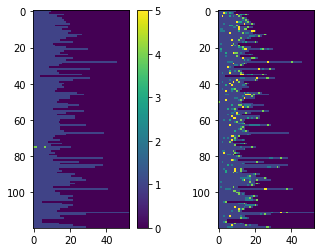

epoch:    2
0.000 perplexity: 1.254 speed: 264 wps
0.083 perplexity: 1.285 speed: 276 wps
0.167 perplexity: 1.272 speed: 266 wps
0.250 perplexity: 1.263 speed: 272 wps
0.333 perplexity: 1.259 speed: 251 wps
0.417 perplexity: 1.259 speed: 253 wps
0.500 perplexity: 1.261 speed: 243 wps
0.583 perplexity: 1.249 speed: 241 wps
0.667 perplexity: 1.241 speed: 244 wps
0.750 perplexity: 1.244 speed: 246 wps
0.833 perplexity: 1.241 speed: 247 wps
0.917 perplexity: 1.239 speed: 248 wps


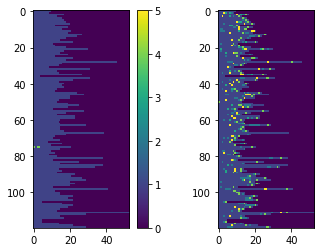

epoch:    3
0.000 perplexity: 1.244 speed: 289 wps
0.083 perplexity: 1.279 speed: 275 wps
0.167 perplexity: 1.277 speed: 271 wps
0.250 perplexity: 1.262 speed: 270 wps
0.333 perplexity: 1.259 speed: 251 wps
0.417 perplexity: 1.258 speed: 235 wps
0.500 perplexity: 1.258 speed: 225 wps
0.583 perplexity: 1.246 speed: 220 wps
0.667 perplexity: 1.237 speed: 221 wps
0.750 perplexity: 1.240 speed: 225 wps
0.833 perplexity: 1.236 speed: 227 wps
0.917 perplexity: 1.234 speed: 231 wps


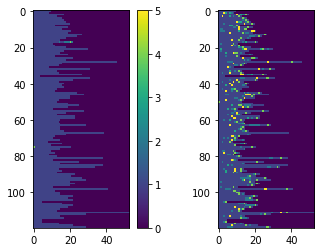

epoch:    4
0.000 perplexity: 1.244 speed: 274 wps
0.083 perplexity: 1.284 speed: 256 wps
0.167 perplexity: 1.281 speed: 241 wps
0.250 perplexity: 1.261 speed: 240 wps
0.333 perplexity: 1.257 speed: 244 wps
0.417 perplexity: 1.254 speed: 243 wps
0.500 perplexity: 1.253 speed: 243 wps
0.583 perplexity: 1.240 speed: 247 wps
0.667 perplexity: 1.232 speed: 248 wps
0.750 perplexity: 1.234 speed: 250 wps
0.833 perplexity: 1.230 speed: 252 wps
0.917 perplexity: 1.230 speed: 252 wps


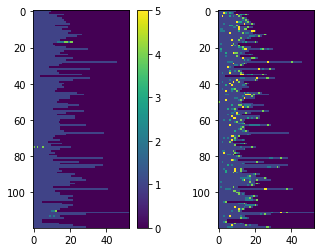

epoch:    5
0.000 perplexity: 1.252 speed: 237 wps
0.083 perplexity: 1.277 speed: 199 wps
0.167 perplexity: 1.258 speed: 217 wps
0.250 perplexity: 1.244 speed: 213 wps
0.333 perplexity: 1.241 speed: 217 wps
0.417 perplexity: 1.243 speed: 224 wps
0.500 perplexity: 1.243 speed: 227 wps
0.583 perplexity: 1.229 speed: 224 wps
0.667 perplexity: 1.220 speed: 228 wps
0.750 perplexity: 1.222 speed: 233 wps
0.833 perplexity: 1.218 speed: 237 wps
0.917 perplexity: 1.216 speed: 238 wps


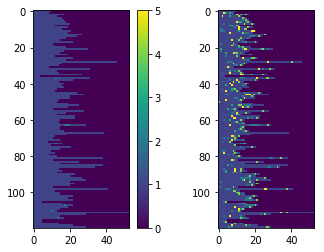

epoch:    6
0.000 perplexity: 1.256 speed: 247 wps
0.083 perplexity: 1.270 speed: 246 wps
0.167 perplexity: 1.256 speed: 257 wps
0.250 perplexity: 1.242 speed: 229 wps
0.333 perplexity: 1.239 speed: 209 wps
0.417 perplexity: 1.238 speed: 214 wps
0.500 perplexity: 1.236 speed: 219 wps
0.583 perplexity: 1.222 speed: 225 wps
0.667 perplexity: 1.214 speed: 230 wps
0.750 perplexity: 1.216 speed: 235 wps
0.833 perplexity: 1.212 speed: 239 wps
0.917 perplexity: 1.211 speed: 242 wps


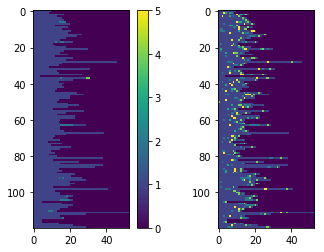

epoch:    7
0.000 perplexity: 1.237 speed: 258 wps
0.083 perplexity: 1.266 speed: 261 wps
0.167 perplexity: 1.260 speed: 267 wps
0.250 perplexity: 1.244 speed: 270 wps
0.333 perplexity: 1.238 speed: 264 wps
0.417 perplexity: 1.235 speed: 259 wps
0.500 perplexity: 1.232 speed: 262 wps
0.583 perplexity: 1.219 speed: 254 wps
0.667 perplexity: 1.210 speed: 247 wps
0.750 perplexity: 1.211 speed: 248 wps
0.833 perplexity: 1.208 speed: 249 wps
0.917 perplexity: 1.208 speed: 251 wps


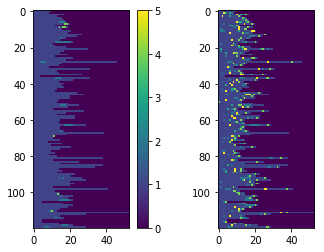

epoch:    8
0.000 perplexity: 1.254 speed: 235 wps
0.083 perplexity: 1.254 speed: 259 wps
0.167 perplexity: 1.239 speed: 268 wps
0.250 perplexity: 1.224 speed: 268 wps
0.333 perplexity: 1.221 speed: 262 wps
0.417 perplexity: 1.220 speed: 263 wps
0.500 perplexity: 1.217 speed: 260 wps
0.583 perplexity: 1.204 speed: 259 wps
0.667 perplexity: 1.196 speed: 261 wps
0.750 perplexity: 1.197 speed: 257 wps
0.833 perplexity: 1.194 speed: 257 wps
0.917 perplexity: 1.196 speed: 259 wps


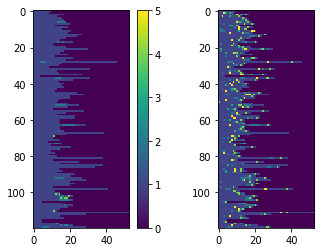

epoch:    9
0.000 perplexity: 1.232 speed: 245 wps
0.083 perplexity: 1.238 speed: 254 wps
0.167 perplexity: 1.229 speed: 247 wps
0.250 perplexity: 1.216 speed: 255 wps
0.333 perplexity: 1.217 speed: 255 wps
0.417 perplexity: 1.215 speed: 254 wps
0.500 perplexity: 1.210 speed: 253 wps
0.583 perplexity: 1.198 speed: 250 wps
0.667 perplexity: 1.190 speed: 254 wps
0.750 perplexity: 1.193 speed: 256 wps
0.833 perplexity: 1.189 speed: 256 wps
0.917 perplexity: 1.188 speed: 255 wps


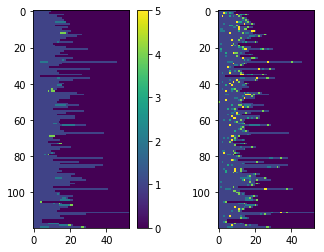

epoch:   10
0.000 perplexity: 1.265 speed: 242 wps
0.083 perplexity: 1.240 speed: 268 wps
0.167 perplexity: 1.228 speed: 260 wps
0.250 perplexity: 1.213 speed: 258 wps
0.333 perplexity: 1.210 speed: 252 wps
0.417 perplexity: 1.207 speed: 256 wps
0.500 perplexity: 1.204 speed: 252 wps
0.583 perplexity: 1.192 speed: 251 wps
0.667 perplexity: 1.184 speed: 252 wps
0.750 perplexity: 1.186 speed: 250 wps
0.833 perplexity: 1.184 speed: 253 wps
0.917 perplexity: 1.182 speed: 255 wps


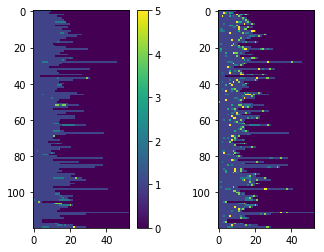

INFO:tensorflow:ckpt_files/model.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
epoch:   11
0.000 perplexity: 1.221 speed: 261 wps
0.083 perplexity: 1.218 speed: 273 wps
0.167 perplexity: 1.211 speed: 270 wps
0.250 perplexity: 1.199 speed: 268 wps
0.333 perplexity: 1.200 speed: 259 wps
0.417 perplexity: 1.199 speed: 258 wps
0.500 perplexity: 1.196 speed: 256 wps
0.583 perplexity: 1.185 speed: 253 wps
0.667 perplexity: 1.177 speed: 257 wps
0.750 perplexity: 1.180 speed: 256 wps
0.833 perplexity: 1.176 speed: 257 wps
0.917 perplexity: 1.174 speed: 259 wps


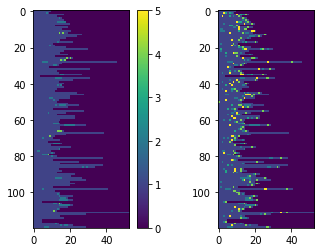

epoch:   12
0.000 perplexity: 1.200 speed: 277 wps
0.083 perplexity: 1.215 speed: 280 wps
0.167 perplexity: 1.231 speed: 278 wps
0.250 perplexity: 1.213 speed: 269 wps
0.333 perplexity: 1.206 speed: 272 wps
0.417 perplexity: 1.202 speed: 274 wps
0.500 perplexity: 1.199 speed: 274 wps
0.583 perplexity: 1.187 speed: 270 wps
0.667 perplexity: 1.178 speed: 268 wps
0.750 perplexity: 1.179 speed: 270 wps
0.833 perplexity: 1.174 speed: 269 wps
0.917 perplexity: 1.174 speed: 271 wps


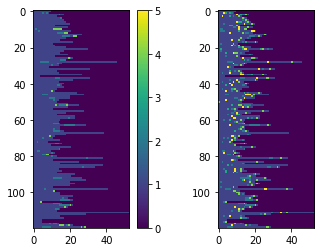

epoch:   13
0.000 perplexity: 1.199 speed: 278 wps
0.083 perplexity: 1.197 speed: 258 wps
0.167 perplexity: 1.207 speed: 256 wps
0.250 perplexity: 1.193 speed: 262 wps
0.333 perplexity: 1.191 speed: 268 wps
0.417 perplexity: 1.188 speed: 261 wps
0.500 perplexity: 1.185 speed: 265 wps
0.583 perplexity: 1.175 speed: 266 wps
0.667 perplexity: 1.167 speed: 260 wps
0.750 perplexity: 1.170 speed: 260 wps
0.833 perplexity: 1.165 speed: 257 wps
0.917 perplexity: 1.166 speed: 258 wps


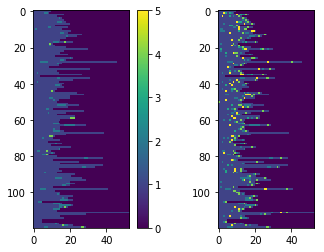

epoch:   14
0.000 perplexity: 1.193 speed: 223 wps
0.083 perplexity: 1.185 speed: 227 wps
0.167 perplexity: 1.190 speed: 225 wps
0.250 perplexity: 1.179 speed: 239 wps
0.333 perplexity: 1.178 speed: 248 wps
0.417 perplexity: 1.177 speed: 246 wps
0.500 perplexity: 1.177 speed: 244 wps
0.583 perplexity: 1.167 speed: 241 wps
0.667 perplexity: 1.159 speed: 240 wps
0.750 perplexity: 1.162 speed: 244 wps
0.833 perplexity: 1.159 speed: 247 wps
0.917 perplexity: 1.158 speed: 250 wps


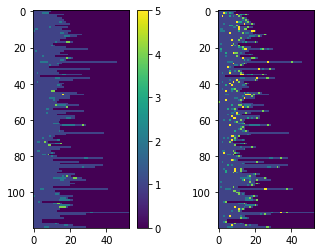

epoch:   15
0.000 perplexity: 1.194 speed: 244 wps
0.083 perplexity: 1.176 speed: 252 wps
0.167 perplexity: 1.183 speed: 262 wps
0.250 perplexity: 1.172 speed: 256 wps
0.333 perplexity: 1.171 speed: 253 wps
0.417 perplexity: 1.167 speed: 252 wps
0.500 perplexity: 1.167 speed: 240 wps
0.583 perplexity: 1.159 speed: 235 wps
0.667 perplexity: 1.152 speed: 233 wps
0.750 perplexity: 1.155 speed: 229 wps
0.833 perplexity: 1.152 speed: 226 wps
0.917 perplexity: 1.155 speed: 223 wps


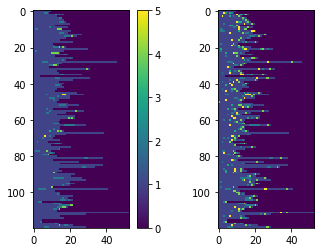

epoch:   16
0.000 perplexity: 1.175 speed: 181 wps
0.083 perplexity: 1.161 speed: 209 wps
0.167 perplexity: 1.179 speed: 231 wps
0.250 perplexity: 1.178 speed: 225 wps
0.333 perplexity: 1.176 speed: 232 wps
0.417 perplexity: 1.172 speed: 237 wps
0.500 perplexity: 1.168 speed: 235 wps
0.583 perplexity: 1.158 speed: 227 wps
0.667 perplexity: 1.150 speed: 219 wps
0.750 perplexity: 1.153 speed: 214 wps
0.833 perplexity: 1.148 speed: 212 wps
0.917 perplexity: 1.146 speed: 211 wps


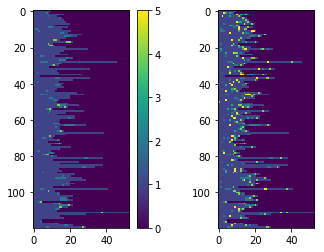

epoch:   17
0.000 perplexity: 1.174 speed: 253 wps
0.083 perplexity: 1.160 speed: 259 wps
0.167 perplexity: 1.195 speed: 261 wps
0.250 perplexity: 1.193 speed: 240 wps
0.333 perplexity: 1.186 speed: 226 wps
0.417 perplexity: 1.181 speed: 220 wps
0.500 perplexity: 1.175 speed: 222 wps
0.583 perplexity: 1.164 speed: 226 wps
0.667 perplexity: 1.155 speed: 228 wps
0.750 perplexity: 1.157 speed: 230 wps
0.833 perplexity: 1.152 speed: 233 wps
0.917 perplexity: 1.150 speed: 234 wps


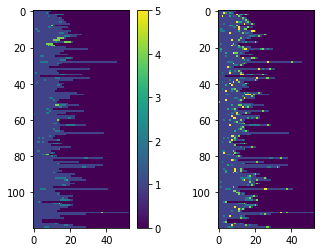

epoch:   18
0.000 perplexity: 1.193 speed: 261 wps
0.083 perplexity: 1.166 speed: 230 wps
0.167 perplexity: 1.165 speed: 247 wps
0.250 perplexity: 1.158 speed: 248 wps
0.333 perplexity: 1.160 speed: 251 wps
0.417 perplexity: 1.157 speed: 247 wps
0.500 perplexity: 1.155 speed: 248 wps
0.583 perplexity: 1.145 speed: 252 wps
0.667 perplexity: 1.140 speed: 255 wps
0.750 perplexity: 1.141 speed: 257 wps
0.833 perplexity: 1.136 speed: 259 wps
0.917 perplexity: 1.136 speed: 259 wps


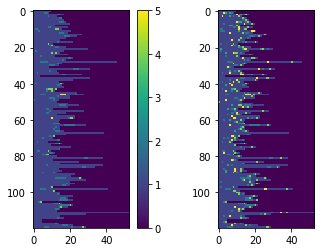

epoch:   19
0.000 perplexity: 1.191 speed: 259 wps
0.083 perplexity: 1.164 speed: 271 wps
0.167 perplexity: 1.171 speed: 248 wps
0.250 perplexity: 1.162 speed: 255 wps
0.333 perplexity: 1.162 speed: 258 wps
0.417 perplexity: 1.160 speed: 256 wps
0.500 perplexity: 1.159 speed: 254 wps
0.583 perplexity: 1.148 speed: 255 wps
0.667 perplexity: 1.141 speed: 253 wps
0.750 perplexity: 1.144 speed: 254 wps
0.833 perplexity: 1.140 speed: 255 wps
0.917 perplexity: 1.141 speed: 255 wps


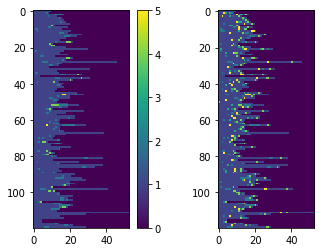

epoch:   20
0.000 perplexity: 1.166 speed: 270 wps
0.083 perplexity: 1.152 speed: 254 wps
0.167 perplexity: 1.167 speed: 251 wps
0.250 perplexity: 1.157 speed: 256 wps
0.333 perplexity: 1.154 speed: 243 wps
0.417 perplexity: 1.153 speed: 238 wps
0.500 perplexity: 1.151 speed: 233 wps
0.583 perplexity: 1.142 speed: 229 wps
0.667 perplexity: 1.135 speed: 228 wps
0.750 perplexity: 1.138 speed: 229 wps
0.833 perplexity: 1.134 speed: 232 wps
0.917 perplexity: 1.133 speed: 231 wps


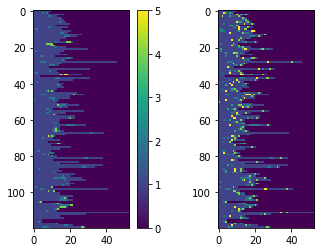

INFO:tensorflow:ckpt_files/model.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.
epoch:   21
0.000 perplexity: 1.159 speed: 274 wps
0.083 perplexity: 1.139 speed: 280 wps
0.167 perplexity: 1.147 speed: 284 wps
0.250 perplexity: 1.140 speed: 285 wps
0.333 perplexity: 1.141 speed: 286 wps
0.417 perplexity: 1.140 speed: 286 wps
0.500 perplexity: 1.137 speed: 286 wps
0.583 perplexity: 1.129 speed: 286 wps
0.667 perplexity: 1.124 speed: 285 wps
0.750 perplexity: 1.128 speed: 285 wps
0.833 perplexity: 1.127 speed: 285 wps
0.917 perplexity: 1.129 speed: 285 wps


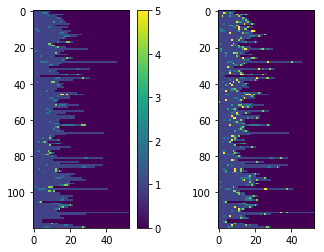

epoch:   22
0.000 perplexity: 1.157 speed: 280 wps
0.083 perplexity: 1.135 speed: 286 wps
0.167 perplexity: 1.148 speed: 286 wps
0.250 perplexity: 1.139 speed: 286 wps
0.333 perplexity: 1.137 speed: 285 wps
0.417 perplexity: 1.135 speed: 285 wps
0.500 perplexity: 1.133 speed: 285 wps
0.583 perplexity: 1.124 speed: 285 wps
0.667 perplexity: 1.119 speed: 286 wps
0.750 perplexity: 1.122 speed: 286 wps
0.833 perplexity: 1.119 speed: 286 wps
0.917 perplexity: 1.121 speed: 286 wps


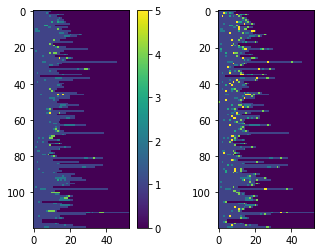

epoch:   23
0.000 perplexity: 1.161 speed: 276 wps
0.083 perplexity: 1.137 speed: 285 wps
0.167 perplexity: 1.146 speed: 287 wps
0.250 perplexity: 1.135 speed: 287 wps
0.333 perplexity: 1.135 speed: 287 wps
0.417 perplexity: 1.131 speed: 285 wps
0.500 perplexity: 1.130 speed: 285 wps
0.583 perplexity: 1.120 speed: 285 wps
0.667 perplexity: 1.116 speed: 285 wps
0.750 perplexity: 1.120 speed: 285 wps
0.833 perplexity: 1.116 speed: 286 wps
0.917 perplexity: 1.116 speed: 285 wps


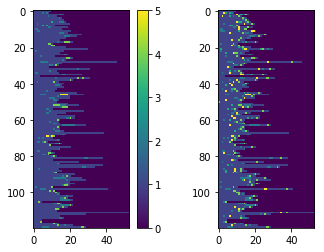

epoch:   24
0.000 perplexity: 1.138 speed: 277 wps
0.083 perplexity: 1.131 speed: 282 wps
0.167 perplexity: 1.149 speed: 285 wps
0.250 perplexity: 1.148 speed: 285 wps
0.333 perplexity: 1.155 speed: 270 wps
0.417 perplexity: 1.148 speed: 268 wps
0.500 perplexity: 1.143 speed: 270 wps
0.583 perplexity: 1.132 speed: 271 wps
0.667 perplexity: 1.127 speed: 263 wps
0.750 perplexity: 1.130 speed: 257 wps
0.833 perplexity: 1.125 speed: 251 wps
0.917 perplexity: 1.123 speed: 247 wps


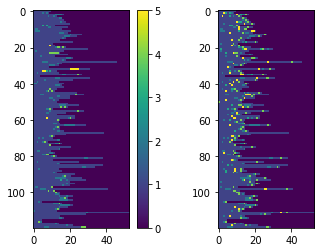

epoch:   25
0.000 perplexity: 1.156 speed: 223 wps
0.083 perplexity: 1.163 speed: 229 wps
0.167 perplexity: 1.161 speed: 225 wps
0.250 perplexity: 1.148 speed: 235 wps
0.333 perplexity: 1.147 speed: 242 wps
0.417 perplexity: 1.141 speed: 246 wps
0.500 perplexity: 1.137 speed: 245 wps
0.583 perplexity: 1.126 speed: 250 wps
0.667 perplexity: 1.120 speed: 254 wps
0.750 perplexity: 1.122 speed: 257 wps
0.833 perplexity: 1.119 speed: 260 wps
0.917 perplexity: 1.116 speed: 262 wps


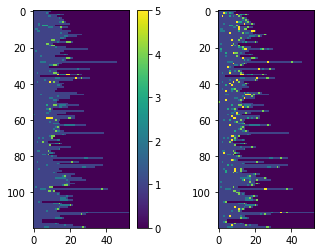

epoch:   26
0.000 perplexity: 1.144 speed: 289 wps
0.083 perplexity: 1.126 speed: 288 wps
0.167 perplexity: 1.135 speed: 290 wps
0.250 perplexity: 1.125 speed: 290 wps
0.333 perplexity: 1.123 speed: 289 wps
0.417 perplexity: 1.119 speed: 289 wps
0.500 perplexity: 1.122 speed: 289 wps
0.583 perplexity: 1.115 speed: 289 wps
0.667 perplexity: 1.110 speed: 289 wps
0.750 perplexity: 1.115 speed: 289 wps
0.833 perplexity: 1.112 speed: 289 wps
0.917 perplexity: 1.111 speed: 289 wps


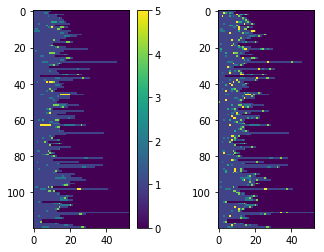

epoch:   27
0.000 perplexity: 1.138 speed: 289 wps
0.083 perplexity: 1.124 speed: 289 wps
0.167 perplexity: 1.135 speed: 290 wps
0.250 perplexity: 1.127 speed: 291 wps
0.333 perplexity: 1.124 speed: 291 wps
0.417 perplexity: 1.121 speed: 290 wps
0.500 perplexity: 1.117 speed: 290 wps
0.583 perplexity: 1.110 speed: 290 wps
0.667 perplexity: 1.107 speed: 290 wps
0.750 perplexity: 1.111 speed: 290 wps
0.833 perplexity: 1.106 speed: 290 wps
0.917 perplexity: 1.106 speed: 290 wps


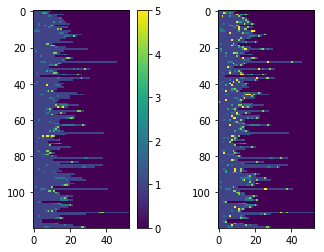

epoch:   28
0.000 perplexity: 1.137 speed: 294 wps
0.083 perplexity: 1.119 speed: 292 wps
0.167 perplexity: 1.128 speed: 290 wps
0.250 perplexity: 1.121 speed: 290 wps
0.333 perplexity: 1.122 speed: 290 wps
0.417 perplexity: 1.120 speed: 289 wps
0.500 perplexity: 1.119 speed: 290 wps
0.583 perplexity: 1.111 speed: 290 wps
0.667 perplexity: 1.107 speed: 290 wps
0.750 perplexity: 1.111 speed: 290 wps
0.833 perplexity: 1.108 speed: 290 wps
0.917 perplexity: 1.107 speed: 290 wps


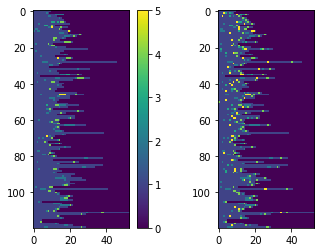

epoch:   29
0.000 perplexity: 1.146 speed: 293 wps
0.083 perplexity: 1.116 speed: 290 wps
0.167 perplexity: 1.122 speed: 290 wps
0.250 perplexity: 1.116 speed: 290 wps
0.333 perplexity: 1.117 speed: 290 wps
0.417 perplexity: 1.115 speed: 290 wps
0.500 perplexity: 1.112 speed: 290 wps
0.583 perplexity: 1.105 speed: 290 wps
0.667 perplexity: 1.101 speed: 290 wps
0.750 perplexity: 1.106 speed: 290 wps
0.833 perplexity: 1.102 speed: 290 wps
0.917 perplexity: 1.101 speed: 290 wps


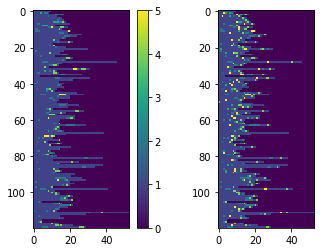

INFO:tensorflow:ckpt_files/model.ckpt-29 is not in all_model_checkpoint_paths. Manually adding it.


In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

for i in range(max_epoch):
    print("epoch: %4d" % i)
    p = run_epoch(sess)
    p = np.vstack(p).reshape(-1, 53)
    f1 = plt.subplot(121)
    i1 = f1.imshow(p, vmin=0, vmax=5)
    plt.colorbar(i1)
    f2 = plt.subplot(122)
    f2.imshow(tr_l[: p.shape[0]], vmin=0, vmax=5)
    plt.show()
    if i % 10 == 0 or i + 1 == max_epoch:
        saver.save(sess, ckpt_path, global_step=i, write_meta_graph=False)
    
    #saver.restore(sess, ckpt_path + "-0" )
    
coord.request_stop()

coord.join(threads)

In [13]:
ppd = pd.DataFrame(p)

In [14]:
lpd = pd.DataFrame(label[:130])

In [24]:
m = (lpd != 0) 
total_size = m.sum().sum()
acc_size = ((ppd == lpd) & m).sum().sum()
acc = 1.0 * acc_size / total_size
print("total_size: %d, acc_size: %d, acc: %.3f" % (total_size, acc_size, acc))

total_size: 2461, acc_size: 2396, acc: 0.974


In [26]:
m2 = (lpd > 1)
pos_size = m2.sum().sum()
pos_p = lpd[((ppd == lpd) & m2)]
pos_acc_size = ((ppd == lpd) & m2).sum().sum()
pos_acc = 1.0 * pos_acc_size / pos_size
print("pos_size: %d, pos_acc_size: %d, pos_acc: %.3f" % (pos_size, pos_acc_size, pos_acc))

total_size: 388, acc_size: 345, acc: 0.889


In [27]:
neg_size = total_size - pos_size
neg_acc_size = acc_size - pos_acc_size
neg_acc = 1.0 * neg_acc_size / neg_size
print("neg_size: %d, neg_acc_size: %d, neg_acc: %.3f" % (neg_size, neg_acc_size, neg_acc))

neg_size: 2073, neg_acc_size: 2051, neg_acc: 0.989


In [21]:
pos_l = lpd[m2]

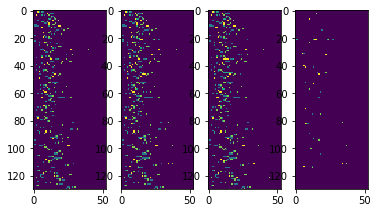

In [22]:
f1 = plt.subplot(141)
i1 = f1.imshow(pos_p.fillna(0).values, vmin=0, vmax=5)
f2 = plt.subplot(142)
f2.imshow(pos_l.fillna(0).values, vmin=0, vmax=5)
f3 = plt.subplot(143)
f3.imshow(ppd[ppd>1].fillna(0).values, vmin=0, vmax=5)
#plt.colorbar(i1)
f4 = plt.subplot(144)
f4.imshow(lpd[((ppd != lpd) & m2)].fillna(0).values, vmin=0, vmax=5)
plt.show()